In [1]:
import os
import glob
import shutil
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Bi-Encoder Table and Figures

In [ ]:
df_list = []

# read, preprocess and concatenate all csv files for each experience
for csv_file in glob.glob('results/bi-encoder/*/*.csv'):
    df = pd.read_csv(csv_file)
    model,seed,_ = csv_file.split('/')[-2].split('_')
    seed = int(seed[-1])
    df["model"] = model
    df["seed"] = seed
    df.drop(columns=["epoch","steps"], inplace=True)
    new_cols = df.columns[-2:].tolist() + df.columns[:-2].tolist()
    df = df[new_cols]
    df_list.append(df)

full_df = pd.concat(df_list)
threshold_cols =[c for c in full_df.columns if "threshold" in c]
full_df.drop(columns=threshold_cols, inplace=True)
full_df.head()
full_df = full_df.melt(id_vars=['model', 'seed'], var_name='metric', value_name='value')
full_df[['distance_metric', 'metric_type']] = full_df['metric'].str.split('_', expand=True)
pivot_df = full_df.pivot_table(index=['model', 'seed', 'distance_metric'], columns='metric_type', values='value').reset_index()
pivot_df.columns.name = None
pivot_df.drop(columns=["ap","seed"], inplace=True) # we drop seed numbre for the mean !!! because it just random caracteristic

In [10]:
pivot_df

,model,distance_metric,Precision,Threshold
0,BioLinkBERT-base,Accuracy,NaN,0.852215
1,BioLinkBERT-base,Average,0.933314,NaN
2,BioLinkBERT-base,F1,NaN,0.822560
3,BioLinkBERT-base,Accuracy,NaN,0.603587
4,BioLinkBERT-base,Average,0.903682,NaN
...,...,...,...,...
100,scibert-scivocab-uncased,Average,0.918584,NaN
101,scibert-scivocab-uncased,F1,NaN,0.705356
102,scibert-scivocab-uncased,Accuracy,NaN,0.826215
103,scibert-scivocab-uncased,Average,0.933145,NaN


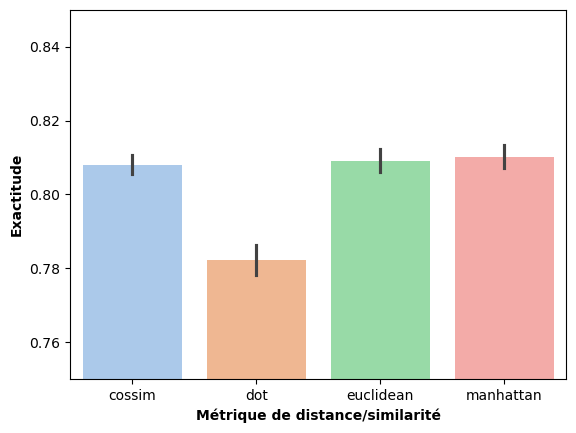

In [79]:
import seaborn as sns

ax = sns.barplot(pivot_df, x="distance_metric", y="accuracy", hue="distance_metric", legend=False, palette="pastel")
ax.set(ylim = (0.75,0.85))
ax.set_xlabel("Métrique de distance/similarité", fontweight="semibold")
ax.set_ylabel("Exactitude", fontweight="semibold")
ax.figure.savefig("out/distance_metric_accuracy.png")

In [5]:
# Group by model and corpus and calculate mean and std
_FORMAT_WITH_STD = "${:.2f}_{{\pm{:.2f}}}$"
_FORMAT_WITHOUT_STD = "{:.2f}"
str_mean_and_std = lambda x : _FORMAT_WITH_STD.format(np.mean(x)*100,np.std(x)*100)

latex_agg_df = pivot_df[pivot_df["distance_metric"] == "cossim"].drop(columns="distance_metric")
latex_agg_df = latex_agg_df.groupby("model").agg(str_mean_and_std)
latex_agg_df = latex_agg_df.sort_values(by="accuracy", ascending=False).head(10)
latex_agg_df = latex_agg_df.reset_index()
latex_agg_df.columns = [ "\\textbf{" + c + "}" for c in latex_agg_df.columns]
latex_agg_df

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_155235/3190276349.py:2: SyntaxWarning: invalid escape sequence '\p'
  _FORMAT_WITH_STD = "${:.2f}_{{\pm{:.2f}}}$"


,\textbf{model},\textbf{accuracy},\textbf{f1},\textbf{precision},\textbf{recall}
0,BiomedNLP-PubMedBERT-base-uncased-abstract,$81.65_{\pm0.45}$,$56.96_{\pm1.67}$,$58.23_{\pm5.08}$,$56.39_{\pm4.36}$
1,bert-base-uncased,$81.25_{\pm0.82}$,$52.71_{\pm3.97}$,$53.30_{\pm7.42}$,$53.89_{\pm8.07}$
2,BioLinkBERT-base,$80.92_{\pm0.64}$,$51.05_{\pm4.58}$,$46.62_{\pm5.55}$,$58.06_{\pm9.23}$
3,biobert-base-cased-v1.2,$80.73_{\pm0.34}$,$53.45_{\pm0.81}$,$48.37_{\pm3.86}$,$60.56_{\pm5.02}$
4,BiomedNLP-PubMedBERT-base-uncased-abstract-ful...,$80.66_{\pm0.65}$,$49.41_{\pm5.93}$,$37.94_{\pm7.40}$,$76.67_{\pm13.22}$
5,scibert-scivocab-uncased,$80.53_{\pm0.42}$,$53.18_{\pm3.58}$,$46.42_{\pm9.05}$,$66.67_{\pm10.21}$
6,all-mpnet-base-v2,$79.87_{\pm0.30}$,$42.31_{\pm1.38}$,$30.10_{\pm4.12}$,$75.83_{\pm11.27}$


In [7]:
latex_agg_df.to_latex(
    "results/bi-encoder_results.tex", 
    caption="Performances des modèles pour l'approche bi-encodeur",
    label="tab:outcome-sim-bi-encoder-results",
    float_format="%.2f",
    index=False,
    position="!ht",
    multicolumn_format='c',
)

# Cross encoder Table and figures

In [14]:
df_list = []

# read, preprocess and concatenate all csv files for each experience
for csv_file in glob.glob('results/cross-encoder/*/*.csv'):
    df = pd.read_csv(csv_file)
    model,seed,_ = csv_file.split('/')[-2].split('_')
    seed = int(seed[-1])
    df["model"] = model
    df["seed"] = seed
    df.drop(columns=["epoch","steps"], inplace=True)
    new_cols = df.columns[-2:].tolist() + df.columns[:-2].tolist()
    df = df[new_cols]
    df_list.append(df)

full_df = pd.concat(df_list)
full_df = full_df.drop(columns=["seed","Accuracy_Threshold","F1_Threshold","Average_Precision"])
full_df

,model,Accuracy,F1,Precision,Recall
0,biobert-base-cased-v1.2,0.910891,0.838323,0.736842,0.972222
0,scibert-scivocab-uncased,0.937294,0.874172,0.835443,0.916667
0,BioLinkBERT-base,0.947195,0.890411,0.878378,0.902778
0,scibert-scivocab-uncased,0.947195,0.891892,0.868421,0.916667
0,BiomedNLP-PubMedBERT-base-uncased-abstract-ful...,0.943894,0.878378,0.855263,0.902778
0,all-mpnet-base-v2,0.910891,0.830189,0.758621,0.916667
0,BiomedNLP-PubMedBERT-base-uncased-abstract,0.960396,0.920000,0.884615,0.958333
0,scibert-scivocab-uncased,0.940594,0.874172,0.835443,0.916667
0,all-mpnet-base-v2,0.910891,0.828025,0.764706,0.902778
0,BioLinkBERT-base,0.947195,0.890411,0.878378,0.902778


In [15]:
# Group by model and corpus and calculate mean and std
_FORMAT_WITH_STD = "${:.2f}_{{\pm{:.2f}}}$"
_FORMAT_WITHOUT_STD = "{:.2f}"
str_mean_and_std = lambda x : _FORMAT_WITH_STD.format(np.mean(x)*100,np.std(x)*100)

latex_agg_df = full_df.groupby("model").agg(str_mean_and_std)
latex_agg_df = latex_agg_df.sort_values(by="Accuracy", ascending=False).head(10)
latex_agg_df = latex_agg_df.reset_index()
latex_agg_df.columns = [ "\\textbf{" + c + "}" for c in latex_agg_df.columns]
latex_agg_df

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_155235/3834221028.py:2: SyntaxWarning: invalid escape sequence '\p'
  _FORMAT_WITH_STD = "${:.2f}_{{\pm{:.2f}}}$"


,\textbf{model},\textbf{Accuracy},\textbf{F1},\textbf{Precision},\textbf{Recall}
0,BiomedNLP-PubMedBERT-base-uncased-abstract,$95.58_{\pm0.26}$,$91.07_{\pm0.55}$,$87.59_{\pm2.25}$,$95.00_{\pm2.99}$
1,BioLinkBERT-base,$94.92_{\pm0.40}$,$89.25_{\pm0.92}$,$89.70_{\pm1.73}$,$88.89_{\pm2.48}$
2,scibert-scivocab-uncased,$94.19_{\pm0.34}$,$88.06_{\pm0.65}$,$85.28_{\pm2.13}$,$91.11_{\pm1.88}$
3,BiomedNLP-PubMedBERT-base-uncased-abstract-ful...,$93.99_{\pm0.82}$,$87.21_{\pm1.46}$,$86.45_{\pm6.04}$,$88.61_{\pm4.60}$
4,biobert-base-cased-v1.2,$91.75_{\pm0.47}$,$83.77_{\pm0.83}$,$78.85_{\pm2.94}$,$89.72_{\pm4.61}$
5,bert-base-uncased,$91.68_{\pm1.05}$,$82.39_{\pm1.82}$,$81.66_{\pm7.12}$,$84.17_{\pm6.00}$
6,all-mpnet-base-v2,$91.55_{\pm0.82}$,$82.96_{\pm1.14}$,$80.16_{\pm4.53}$,$86.39_{\pm3.87}$


In [16]:
latex_agg_df.to_latex(
    "results/cross-encoder_results.tex", 
    caption="Performances des modèles pour l'approche cross-encodeur",
    label="tab:outcome-sim-cross-encoder-results",
    float_format="%.2f",
    index=False,
    position="!ht",
    multicolumn_format='c',
)